# PRIMERA PRUEBA DE ENTRENAMIENTO DEL MODELO

In [167]:
# Importamos las librerías necesarias:

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from typing import Union
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
import os

In [100]:
#Montamos google drive para poder leer el csv

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# Leemos el archivo csv ya limpio de los pasos anteriores:

base_df = pd.read_csv('/content/drive/MyDrive/DATASETS/dataset_final_glaciar_temperatura.csv')
base_df.head()

,Unnamed: 0,NAME,WGMS_ID,LATITUDE,LONGITUDE,YEAR,MEDIAN_ELEVATION,LENGTH,AREA_general,ET_SURGE,...,RX1DAY_rcp85,TN,TN_rcp26,TN_rcp85,T,T_rcp26,T_rcp85,CDD,CDD_rcp26,CDD_rcp85
0,8,A NEUVE GLACIER DE L'-N,4615.0,45.946499,7.053080,2010.0,2962.0,1950.0000,884.99999,0.0,...,17.903225,5.780021,6.386044,5.780021,9.793179,9.98806,9.793179,20.983499,22.733585,20.983499
1,9,A NEUVE GLACIER DE L'-S,4614.0,45.935699,7.054440,2010.0,2772.0,1830.0000,1919.00000,0.0,...,17.903225,5.780021,6.386044,5.780021,9.793179,9.98806,9.793179,20.983499,22.733585,20.983499
2,10,AALFOTBREEN,317.0,61.750000,5.650000,1975.0,1230.0,3000.0000,4820.00020,0.0,...,NaN,3.196233,NaN,NaN,4.888330,NaN,NaN,16.708041,NaN,NaN
3,11,AALFOTBREEN,317.0,61.750000,5.650000,1980.0,1230.0,2900.0001,4820.00020,0.0,...,NaN,3.302226,NaN,NaN,5.028051,NaN,NaN,16.041689,NaN,NaN
4,15,ABANO,767.0,42.691349,44.521919,1960.0,3800.0,4099.9999,2000.00000,0.0,...,NaN,4.101532,NaN,NaN,9.111561,NaN,NaN,28.178879,NaN,NaN


In [102]:
# Creamos un nuevo dataset para ver las ventanas de años que tenemos por cada glaciar

years_df = base_df.groupby("NAME").agg(
    min_year=("YEAR", "min"),
    max_year=("YEAR", "max"),
    count=("YEAR", "count"),
)

years_df["year_window_size"] = (years_df["max_year"] - years_df["min_year"] + 1).astype(
    int
)

In [103]:
# Comprobamos resultado:

years_df

,min_year,max_year,count,year_window_size
NAME,,,,
A NEUVE GLACIER DE L'-N,2010.0,2010.0,1,1
A NEUVE GLACIER DE L'-S,2010.0,2010.0,1,1
AALFOTBREEN,1975.0,1980.0,2,6
ABANO,1960.0,2014.0,3,55
ABAY,1975.0,1975.0,1,1
...,...,...,...,...
ZOPKHITO,2014.0,2014.0,1,1
ZORA,1978.0,1978.0,1,1
ZUORT VADRET DA,2009.0,2009.0,1,1


In [104]:
# Comprobamos los glaciares que tienen datos en más de un año ya que el resto no nos servirán

single_year_glaciers = years_df[(years_df["count"] == 1)].index
multi_year_glaciers = years_df[(years_df["count"] > 1)].index

print(len(single_year_glaciers))
print(len(multi_year_glaciers))

2302
564


In [105]:
# Vemos la media de años en los que tenemos datos:

multi_year_df = base_df[base_df["NAME"].isin(multi_year_glaciers)]
multi_year_df.groupby("NAME")["YEAR"].count().mean()

3.099290780141844

<Axes: >

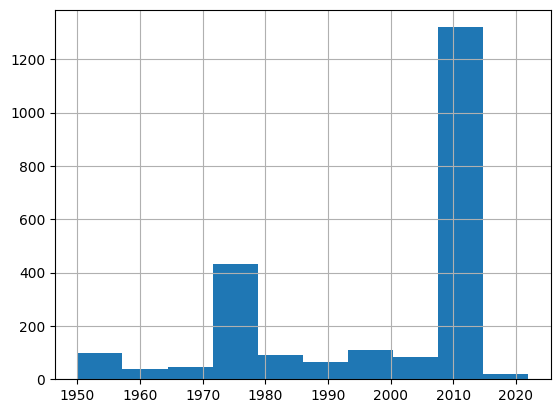

In [106]:
# Hacemos una gráfica de cuáles son los años más comunes:

base_df[base_df["NAME"].isin(single_year_glaciers)]["YEAR"].hist()

In [107]:
# Seleccionamos las columnas:

multi_year_df = multi_year_df[
    [
        "NAME",
        "LATITUDE",
        "LONGITUDE",
        "YEAR",
        "MEDIAN_ELEVATION",
        "LENGTH",
        "AREA_general",
    ]
]

In [108]:
# En los glaciares que tengan años salteados, añadiremos las filas entre medias con datos que se comprendan entre esos años

glacier_names = multi_year_df["NAME"].unique().tolist()


def fill_between_two_years(early_year: pd.Series, late_year: pd.Series) -> pd.DataFrame:
    year_window_size = int(late_year["YEAR"] - early_year["YEAR"] + 1)
    if year_window_size <= 0:
        raise ValueError("late year must be greater than early year")
    if year_window_size == 1:
        return pd.DataFrame(early_year)
    if year_window_size == 2:
        return pd.DataFrame([early_year, late_year])

    years = np.linspace(early_year["YEAR"], late_year["YEAR"], year_window_size)

    median_elevations = np.linspace(
        early_year["MEDIAN_ELEVATION"], late_year["MEDIAN_ELEVATION"], year_window_size
    )
    lengths = np.linspace(early_year["LENGTH"], late_year["LENGTH"], year_window_size)
    areas = np.linspace(
        early_year["AREA_general"], late_year["AREA_general"], year_window_size
    )
    return pd.DataFrame(
        {
            "NAME": early_year["NAME"],
            "YEAR": years,
            "LATITUDE": early_year["LATITUDE"],
            "LONGITUDE": early_year["LONGITUDE"],
            "MEDIAN_ELEVATION": median_elevations,
            "LENGTH": lengths,
            "AREA_general": areas,
        }
    )


def process_glacier_data(glacier_df: pd.DataFrame) -> pd.DataFrame:
    assert (
        glacier_df["NAME"].nunique() == 1
    ), "glacier_df must contain only one glacier name"
    assert len(glacier_df) >= 2, "glacier_df must contain at least two years of data"
    ordered_glacier_df = glacier_df.sort_values("YEAR").reset_index(drop=True)
    ordered_glacier_df = ordered_glacier_df[
        [
            "NAME",
            "YEAR",
            "LATITUDE",
            "LONGITUDE",
            "MEDIAN_ELEVATION",
            "LENGTH",
            "AREA_general",
        ]
    ]
    final_df = pd.DataFrame(columns=ordered_glacier_df.columns)
    for i, row in ordered_glacier_df.iterrows():
        if i == 0:
            continue
        early_year = ordered_glacier_df.iloc[i - 1]
        late_year = ordered_glacier_df.iloc[i]
        filled_in_df = fill_between_two_years(early_year, late_year)
        if final_df.empty:
            final_df = filled_in_df.copy()
        else:
            final_df = pd.concat([final_df, filled_in_df], ignore_index=True)

    final_df = final_df.drop_duplicates(subset=["YEAR"])
    return final_df


filled_in_df = pd.DataFrame()
for glacier_name in glacier_names:
    glacier_df = multi_year_df[multi_year_df["NAME"] == glacier_name]
    num_years = len(glacier_df)
    min_year = glacier_df["YEAR"].min()
    max_year = glacier_df["YEAR"].max()
    year_window_size = max_year - min_year + 1
    if num_years != year_window_size:
        processed_df = process_glacier_data(glacier_df)
    else:
        processed_df = glacier_df.copy()

    if filled_in_df.empty:
        filled_in_df = processed_df.copy()
    else:
        filled_in_df = pd.concat([filled_in_df, processed_df], ignore_index=True)

In [109]:
# Guardamos el dataset

filled_in_df.to_csv(
    "/content/drive/MyDrive/DATASETS/filled_in_glacier_data.csv", index=False
)

In [110]:
# Mostramos su cabecera:

filled_in_df.head()

,NAME,YEAR,LATITUDE,LONGITUDE,MEDIAN_ELEVATION,LENGTH,AREA_general
0,AALFOTBREEN,1975.0,61.75,5.65,1230.0,3000.00000,4820.0002
1,AALFOTBREEN,1976.0,61.75,5.65,1230.0,2980.00002,4820.0002
2,AALFOTBREEN,1977.0,61.75,5.65,1230.0,2960.00004,4820.0002
3,AALFOTBREEN,1978.0,61.75,5.65,1230.0,2940.00006,4820.0002
4,AALFOTBREEN,1979.0,61.75,5.65,1230.0,2920.00008,4820.0002


In [111]:
# Añadiremos tres columnas de las variables a predecir normalizadas, es decir el cambio que ha habido en esas tres features con respecto al año anterior:

look_forward_rows = []
for glacier_name in glacier_names:
    glacier_df = filled_in_df[filled_in_df["NAME"] == glacier_name]
    for year in glacier_df["YEAR"]:
        next_year = year + 1
        if next_year not in glacier_df["YEAR"].values:
            continue
        current_year = glacier_df[glacier_df["YEAR"] == year]
        next_year = glacier_df[glacier_df["YEAR"] == next_year]

        area_norm = (
            next_year["AREA_general"].values[0] - current_year["AREA_general"].values[0]
        ) / current_year["AREA_general"].values[0]
        length_norm = (
            next_year["LENGTH"].values[0] - current_year["LENGTH"].values[0]
        ) / current_year["LENGTH"].values[0]
        elevation_norm = (
            next_year["MEDIAN_ELEVATION"].values[0]
            - current_year["MEDIAN_ELEVATION"].values[0]
        ) / current_year["MEDIAN_ELEVATION"].values[0]

        look_forward_row = {
            "NAME": glacier_name,
            "YEAR": year,
            "LATITUDE": current_year["LATITUDE"].values[0],
            "LONGITUDE": current_year["LONGITUDE"].values[0],
            "AREA_general": current_year["AREA_general"].values[0],
            "LENGTH": current_year["LENGTH"].values[0],
            "MEDIAN_ELEVATION": current_year["MEDIAN_ELEVATION"].values[0],
            "AREA_NORM": area_norm,
            "LENGTH_NORM": length_norm,
            "ELEVATION_NORM": elevation_norm,
        }
        look_forward_rows.append(look_forward_row)

look_forward_df = pd.DataFrame(look_forward_rows)

In [112]:
# Leemos el dataset de temperaturas:

temperatures_df = pd.read_csv(
    "/content/drive/MyDrive/DATASETS/Copia de all_data_predictions_1950_2100.csv"
).rename(columns={"Year": "YEAR"})

In [113]:
# Mergeamos ambos datasets en base a las coordenadas más cercanas y al año

def find_closest_temperature_measurement(
    temp_df: pd.DataFrame, year: int, latitude: float, longitude: float
) -> Union[pd.Series, None]:
    year_df = temp_df[temp_df["YEAR"] == year]
    if len(year_df) == 0:
        return None
    year_coords = year_df[["Latitude", "Longitude"]]
    coords = np.array([latitude, longitude]).reshape(1, -1)
    distances = np.linalg.norm(year_coords - coords, axis=1)
    closest_index = distances.argmin()
    return year_df.iloc[closest_index]


def merge_temperature_data(
    glacier_data: pd.DataFrame, temp_df: pd.DataFrame
) -> pd.DataFrame:
    merged_data = glacier_data.copy()
    merged_data["temp_index"] = -1
    for i, row in glacier_data.iterrows():
        temperature_data = find_closest_temperature_measurement(
            temp_df, row["YEAR"], row["LATITUDE"], row["LONGITUDE"]
        )
        if temperature_data is None:
            continue
        merged_data.loc[i, "temp_index"] = temperature_data.name
    merged_data = merged_data.merge(
        temp_df, left_on="temp_index", right_index=True, suffixes=("", "_temp")
    )
    merged_data.drop(columns=["temp_index"], inplace=True)
    return merged_data


merged_df = merge_temperature_data(look_forward_df, temperatures_df)

In [114]:
# Ordenamos el dataset en base al nombre y al año:

merged_df = merged_df.sort_values(by=["NAME", "YEAR"]).reset_index(drop=True)

In [115]:
# Mostramos su cabecera:

merged_df

,NAME,YEAR,LATITUDE,LONGITUDE,AREA_general,LENGTH,MEDIAN_ELEVATION,AREA_NORM,LENGTH_NORM,ELEVATION_NORM,...,RX1DAY_rcp85,TN,TN_rcp26,TN_rcp85,T,T_rcp26,T_rcp85,CDD,CDD_rcp26,CDD_rcp85
0,AALFOTBREEN,1975.0,61.750,5.650000,4820.0002,3000.00000,1230.0,0.0,-0.006667,0.000000,...,NaN,3.196233,NaN,NaN,4.888330,NaN,NaN,16.708041,NaN,NaN
1,AALFOTBREEN,1976.0,61.750,5.650000,4820.0002,2980.00002,1230.0,0.0,-0.006711,0.000000,...,NaN,3.271063,NaN,NaN,4.980567,NaN,NaN,15.424771,NaN,NaN
2,AALFOTBREEN,1977.0,61.750,5.650000,4820.0002,2960.00004,1230.0,0.0,-0.006757,0.000000,...,NaN,3.339577,NaN,NaN,5.041897,NaN,NaN,16.496363,NaN,NaN
3,AALFOTBREEN,1978.0,61.750,5.650000,4820.0002,2940.00006,1230.0,0.0,-0.006803,0.000000,...,NaN,3.262597,NaN,NaN,4.961934,NaN,NaN,15.813241,NaN,NaN
4,AALFOTBREEN,1979.0,61.750,5.650000,4820.0002,2920.00008,1230.0,0.0,-0.006849,0.000000,...,NaN,3.481872,NaN,NaN,5.160221,NaN,NaN,16.243231,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11715,ZONGO,2010.0,-16.274,-68.143898,1909.6849,2750.00000,5420.0,0.0,0.000000,0.000000,...,18.958356,NaN,5.445929,4.754838,NaN,10.076916,10.011867,NaN,49.685173,46.836241
11716,ZONGO,2011.0,-16.274,-68.143898,1909.6849,2750.00000,5420.0,0.0,0.000000,0.000000,...,19.319030,NaN,5.605263,4.489732,NaN,10.240901,9.798127,NaN,44.201496,54.210129
11717,ZONGO,2012.0,-16.274,-68.143898,1909.6849,2750.00000,5420.0,0.0,-0.005455,0.000000,...,19.088182,NaN,5.580012,4.468627,NaN,10.285772,9.784345,NaN,48.660480,50.876549
11718,ZONGO,2013.0,-16.274,-68.143898,1909.6849,2734.99990,5420.0,0.0,-0.006399,0.009594,...,19.482425,NaN,5.592238,4.820475,NaN,10.339134,10.083510,NaN,48.713913,51.365032


In [116]:
# Drop the original columns, firsts and lasts
agged_df = merged_df.drop(columns=["LENGTH", "AREA_general", "MEDIAN_ELEVATION"])

(-1.0, 1.0)

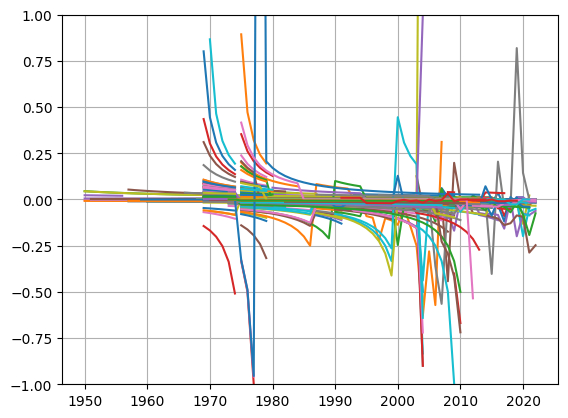

In [117]:
for glacier in agged_df["NAME"].unique():
    glacier_df = agged_df[agged_df["NAME"] == glacier]
    plt.plot(glacier_df["YEAR"], glacier_df["AREA_NORM"], label=glacier)

plt.grid()
plt.ylim(-1, 1)

In [118]:
final_df = agged_df.copy()
# Rellenaremos las variables T, TN, PR, CDD, RX1DAY con los valores del escenario pesimista:

final_df["T"] = final_df["T"].fillna(final_df["T_rcp85"])
final_df["TN"] = final_df["TN"].fillna(final_df["TN_rcp85"])
final_df["PR"] = final_df["PR"].fillna(final_df["PR_rcp85"])
final_df["CDD"] = final_df["CDD"].fillna(final_df["CDD_rcp85"])
final_df["RX1DAY"] = final_df["RX1DAY"].fillna(final_df["RX1DAY_rcp85"])

# Definimos las columnas que va a tener el dataset a tratar

final_df = final_df[
    [
        "NAME",
        "YEAR",
        "LATITUDE",
        "LONGITUDE",
        "T",
        "TN",
        "PR",
        "CDD",
        "RX1DAY",
        "LENGTH_NORM",
        "AREA_NORM",
        "ELEVATION_NORM",
    ]
]

In [119]:
# Exportamos el dataset:

final_df.to_csv("/content/drive/MyDrive/DATASETS/normed_2year.csv", index=False)

#Modelo para predecir el cambio de Área con respecto al año anterior.

In [120]:
# Definimos las columnas para el dataset de entrenamiento del modelo de área:

DF_area = final_df[
    [
        "LATITUDE",
        "LONGITUDE",
        "T",
        "TN",
        "PR",
        "CDD",
        "RX1DAY",
        "AREA_NORM",
    ]
]


In [121]:
# Dividimos el dataset en X e y:

X_area = DF_area.drop(columns=["AREA_NORM"])
y_area = DF_area["AREA_NORM"]

# Dividimos el dataset en train y test:

X_train, X_test, y_train, y_test = train_test_split(
    X_area, y_area, test_size=0.2, random_state=2345325
)

In [122]:
# Creamos un regresor RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=2345325)

# Entrenamos el modelo de área:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=2345325)

In [123]:
# Predecir los valores del conjunto de entrenamiento usando el modelo entrenado
y_train_pred = rf.predict(X_train)

# Calcular los errores de predicción del conjunto de entrenamiento
train_errors = y_train - y_train_pred

# Calcular el error cuadrático medio (MSE) para el conjunto de entrenamiento
train_mse = np.mean(train_errors**2)

# Calcular la raíz del error cuadrático medio (RMSE) para el conjunto de entrenamiento
train_rmse = np.sqrt(train_mse)

# Calcular el RMSE relativo dividiendo el RMSE por el valor medio de y_train
train_rmse_rel = train_rmse / y_train.mean()

# Calcular el coeficiente de determinación (R²) para el conjunto de entrenamiento
train_r2 = r2_score(y_train, y_train_pred)

# Imprimir las métricas calculadas
print(f"Train RMSE: {train_rmse}")
print(f"Train RMSE Rel: {train_rmse_rel}")
print(f"Train R²: {train_r2}")


Train RMSE: 0.062438753518831484
Train RMSE Rel: -9.028784499012735
Train R²: 0.688069201356492


In [124]:
# Predecir los valores del conjunto de prueba usando el modelo entrenado
y_test_pred = rf.predict(X_test)

# Calcular los errores de predicción del conjunto de prueba
test_errors = y_test - y_test_pred

# Calcular el error cuadrático medio (MSE) para el conjunto de prueba
test_mse = np.mean(test_errors**2)

# Calcular la raíz del error cuadrático medio (RMSE) para el conjunto de prueba
test_rmse = np.sqrt(test_mse)

# Calcular el RMSE relativo dividiendo el RMSE por el valor medio de y_test
test_rmse_rel = test_rmse / y_test.mean()

# Calcular el coeficiente de determinación (R²) para el conjunto de prueba
test_r2 = r2_score(y_test, y_test_pred)

# Imprimir las métricas calculadas
print(f"Test RMSE: {test_rmse}")
print(f"Test RMSE relative: {test_rmse_rel}")
print(f"Test R²: {test_r2}")


Test RMSE: 0.046894159571978726
Test RMSE relative: -5.486944627701706
Test R²: 0.1233690559288525


<Axes: >

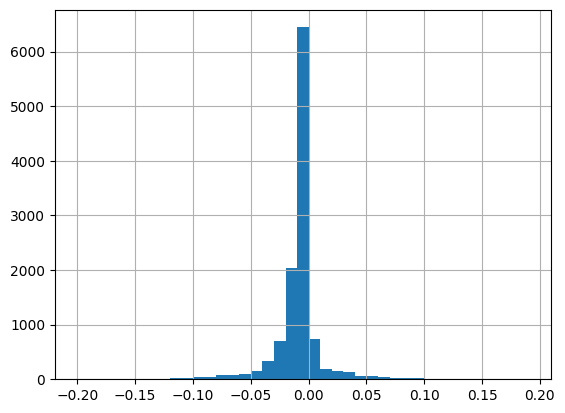

In [125]:
final_df["AREA_NORM"].hist(bins=np.arange(-0.2, 0.2, 0.01))

<Axes: >

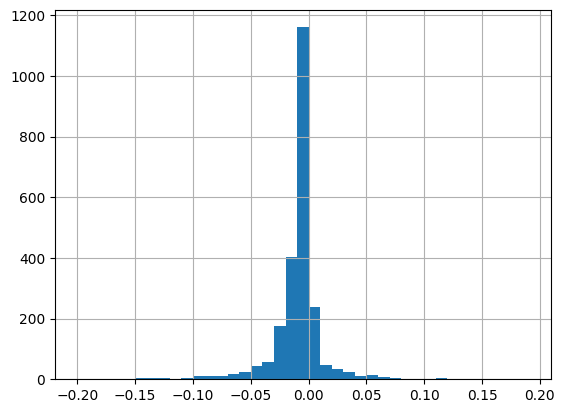

In [126]:
pd.Series(y_test_pred).hist(bins=np.arange(-0.2, 0.2, 0.01))

#Modelo para predecir el cambio de Longitud con respecto al año anterior.

In [127]:
# Definimos las columnas para el dataset de entrenamiento del modelo de longitud:

DF_length = final_df[
    [
        "LATITUDE",
        "LONGITUDE",
        "T",
        "TN",
        "PR",
        "CDD",
        "RX1DAY",
        "LENGTH_NORM",
    ]
]

In [128]:
# Dividimos el dataset en X e y:

X_length = DF_length.drop(columns=["LENGTH_NORM"])
y_length = DF_length["LENGTH_NORM"]

# Dividimos el dataset en train y test:

X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(
    X_length, y_length, test_size=0.2, random_state=2345325
)

In [129]:
# Crear un regresor RandomForest:

rf_L = RandomForestRegressor(n_estimators=100, random_state=2345325, max_depth= 30)

# Entrenamos el modelo de longitud:

rf_L.fit(X_train_L, y_train_L)

RandomForestRegressor(max_depth=30, random_state=2345325)

In [130]:
# Predicciones en el conjunto de entrenamiento usando el modelo de bosques aleatorios
y_train_pred_L = rf_L.predict(X_train_L)

# Calculando los errores en el conjunto de entrenamiento
train_errors = y_train_L - y_train_pred_L

# Calculando el error cuadrático medio (Mean Squared Error, MSE) en el conjunto de entrenamiento
train_mse = np.mean(train_errors**2)

# Calculando la raíz del error cuadrático medio (Root Mean Squared Error, RMSE) en el conjunto de entrenamiento
train_rmse = np.sqrt(train_mse)

# Calculando el RMSE relativo en el conjunto de entrenamiento
train_rmse_rel = train_rmse / y_train.mean()

# Calculando el coeficiente de determinación (R-squared) en el conjunto de entrenamiento
train_r2 = r2_score(y_train, y_train_pred)

# Imprimiendo los resultados del entrenamiento
print(f"Train RMSE: {train_rmse}")  # Imprime el RMSE en el conjunto de entrenamiento
print(f"Train R²: {train_r2}")  # Imprime el coeficiente de determinación en el conjunto de entrenamiento
print(f"Train RMSE Rel: {train_rmse_rel}")  # Imprime el RMSE relativo en el conjunto de entrenamiento


Train RMSE: 0.4723019971716127
Train R²: 0.688069201356492
Train RMSE Rel: -68.29593338421945


In [131]:
# Predicciones en el conjunto de prueba usando el modelo de bosques aleatorios
y_test_pred_L = rf_L.predict(X_test_L)

# Calculando los errores en el conjunto de prueba
test_errors = y_test_L - y_test_pred_L

# Calculando el error cuadrático medio (Mean Squared Error, MSE) en el conjunto de prueba
test_mse = np.mean(test_errors**2)

# Calculando la raíz del error cuadrático medio (Root Mean Squared Error, RMSE) en el conjunto de prueba
test_rmse = np.sqrt(test_mse)

# Calculando el RMSE relativo en el conjunto de prueba
test_rmse_rel = test_rmse / y_test.mean()

# Calculando el coeficiente de determinación (R-squared) en el conjunto de prueba
test_r2 = r2_score(y_test, y_test_pred_L)

# Imprimiendo los resultados del conjunto de prueba
print(f"Test RMSE: {test_rmse}")  # Imprime el RMSE en el conjunto de prueba
print(f"Test RMSE relative: {test_rmse_rel}")  # Imprime el RMSE relativo en el conjunto de prueba
print(f"Test R²: {test_r2}")  # Imprime el coeficiente de determinación en el conjunto de prueba


Test RMSE: 0.11894569317353476
Test RMSE relative: -13.917477956823593
Test R²: -5.490201225995026


<Axes: >

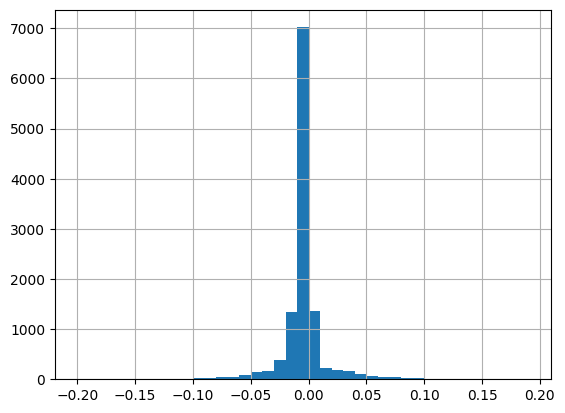

In [132]:
final_df["LENGTH_NORM"].hist(bins=np.arange(-0.2, 0.2, 0.01))

<Axes: >

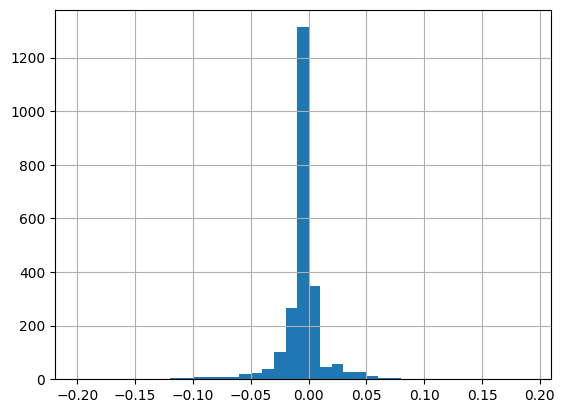

In [133]:
pd.Series(y_test_pred_L).hist(bins=np.arange(-0.2, 0.2, 0.01))

#Modelo para predecir el cambio de Elevación con respecto al año anterior.

In [134]:
# Definimos las columnas para el dataset de entrenamiento del modelo de elevación:

DF_elevation = final_df[
    [
        "LATITUDE",
        "LONGITUDE",
        "T",
        "TN",
        "PR",
        "CDD",
        "RX1DAY",
        "ELEVATION_NORM",
    ]
]

In [135]:
# Dividimos el dataset en X e y:

X_elevation = DF_elevation.drop(columns=["ELEVATION_NORM"])
y_elevation = DF_elevation["ELEVATION_NORM"]

# Dividimos el dataset en train y test:

X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(
    X_elevation, y_elevation, test_size=0.2, random_state=2345325
)

In [136]:
# Crear un regresor RandomForest:

rf_E = RandomForestRegressor(n_estimators=100, random_state=2345325)


# Entrenamos el modelo de elevación:

rf_E.fit(X_train_E, y_train_E)

RandomForestRegressor(random_state=2345325)

In [137]:
# Predicciones en el conjunto de entrenamiento completo usando el modelo de bosques aleatorios
y_train_pred_E = rf_E.predict(X_train)

# Calculando los errores en el conjunto de entrenamiento completo
train_errors = y_train_E - y_train_pred_E

# Calculando el error cuadrático medio (Mean Squared Error, MSE) en el conjunto de entrenamiento completo
train_mse = np.mean(train_errors**2)

# Calculando la raíz del error cuadrático medio (Root Mean Squared Error, RMSE) en el conjunto de entrenamiento completo
train_rmse = np.sqrt(train_mse)

# Calculando el RMSE relativo en el conjunto de entrenamiento completo
train_rmse_rel = train_rmse / y_train.mean()

# Imprimiendo los resultados del conjunto de entrenamiento completo
print(f"Train RMSE: {train_rmse}")  # Imprime el RMSE en el conjunto de entrenamiento completo
print(f"Train RMSE Rel: {train_rmse_rel}")  # Imprime el RMSE relativo en el conjunto de entrenamiento completo


Train RMSE: 0.0034387624297170733
Train RMSE Rel: -0.4972527984860055


In [138]:
# Predicciones en el conjunto de prueba completo usando el modelo de bosques aleatorios
y_test_pred_E = rf_E.predict(X_test)

# Calculando los errores en el conjunto de prueba completo
test_errors = y_test_E - y_test_pred_E

# Calculando el error cuadrático medio (Mean Squared Error, MSE) en el conjunto de prueba completo
test_mse = np.mean(test_errors**2)

# Calculando la raíz del error cuadrático medio (Root Mean Squared Error, RMSE) en el conjunto de prueba completo
test_rmse = np.sqrt(test_mse)

# Calculando el RMSE relativo en el conjunto de prueba completo
test_rmse_rel = test_rmse / y_test.mean()

# Imprimiendo los resultados del conjunto de prueba completo
print(f"Test RMSE: {test_rmse}")  # Imprime el RMSE en el conjunto de prueba completo
print(f"Test RMSE relative: {test_rmse_rel}")  # Imprime el RMSE relativo en el conjunto de prueba completo


Test RMSE: 0.009778048885020372
Test RMSE relative: -1.1441001030568916


<Axes: >

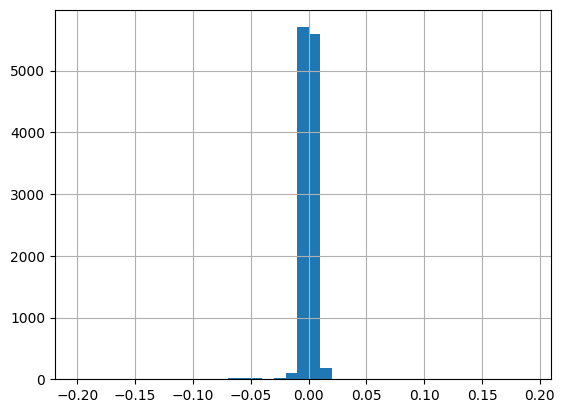

In [139]:
final_df["ELEVATION_NORM"].hist(bins=np.arange(-0.2, 0.2, 0.01))

<Axes: >

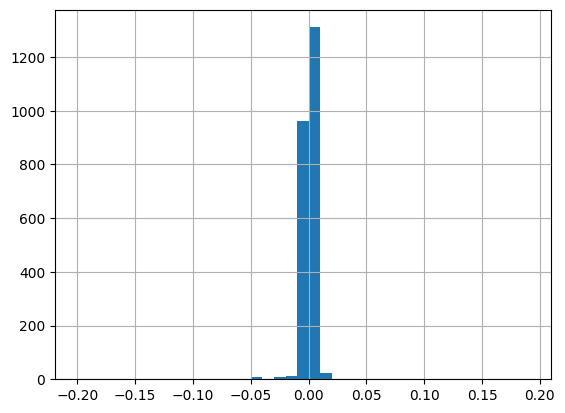

In [140]:
pd.Series(y_test_pred_E).hist(bins=np.arange(-0.2, 0.2, 0.01))

In [141]:
# Haremos una función para añadir filas a cada glaciar desde su último año hasta 2100 para predecir:

predictions_base_df = filled_in_df.groupby("NAME").agg(
    max_year=("YEAR", "max"), lat=("LATITUDE", "first"), lon=("LONGITUDE", "first")
).reset_index(drop=False)

predictions_base_df["year"] = (predictions_base_df["max_year"]).astype(int)
predictions_base_df.drop(columns=["max_year"], inplace=True)

def fill_in_future_years(name,lat,lon,min_year,last_year):
  return pd.DataFrame([{
      "NAME": name,
      "LATITUDE": lat,
      "LONGITUDE": lon,
      "YEAR": year

  } for year in range(min_year,last_year + 1)])

predictions_df = pd.concat([fill_in_future_years(row["NAME"],row["lat"],row["lon"],row["year"],2100) for i,row in predictions_base_df.iterrows()]).reset_index(drop=True)

In [142]:
# Comporbamos resultado:

predictions_df.head()

,NAME,LATITUDE,LONGITUDE,YEAR
0,AALFOTBREEN,61.75,5.65,1980
1,AALFOTBREEN,61.75,5.65,1981
2,AALFOTBREEN,61.75,5.65,1982
3,AALFOTBREEN,61.75,5.65,1983
4,AALFOTBREEN,61.75,5.65,1984


In [143]:
# Resteamos el indice del dataset de temperaturas:

temperatures_df_copy = temperatures_df.copy().reset_index(drop = True)

In [144]:
# Mergeamos ambos datasets en base a las coordenadas más cercanas y al año

def find_closest_temperature_measurement(
    temp_df: pd.DataFrame, year: int, latitude: float, longitude: float
) -> Union[pd.Series, None]:
    year_df = temp_df[temp_df["YEAR"] == year]
    if len(year_df) == 0:
        return None
    year_coords = year_df[["Latitude", "Longitude"]]
    coords = np.array([latitude, longitude]).reshape(1, -1)
    distances = np.linalg.norm(year_coords - coords, axis=1)
    closest_index = distances.argmin()
    return year_df.iloc[closest_index]


def merge_temperature_data(
    glacier_data: pd.DataFrame, temp_df: pd.DataFrame
) -> pd.DataFrame:
    merged_data = glacier_data.copy()
    merged_data["temp_index"] = -1
    for i, row in glacier_data.iterrows():
        temperature_data = find_closest_temperature_measurement(
            temp_df, row["YEAR"], row["LATITUDE"], row["LONGITUDE"]
        )
        if temperature_data is None:
            continue
        merged_data.loc[i, "temp_index"] = temperature_data.name
    merged_data = merged_data.merge(
        temp_df, left_on="temp_index", right_index=True, suffixes=("", "_temp")
    )
    merged_data.drop(columns=["temp_index"], inplace=True)
    return merged_data


future_merged_prediction_df = merge_temperature_data(predictions_df, temperatures_df_copy)

In [145]:
# Comprobamos resultados:

future_merged_prediction_df.sample(20)

,NAME,LATITUDE,LONGITUDE,YEAR,YEAR_temp,Latitude,Longitude,PR,PR_rcp26,PR_rcp85,...,RX1DAY_rcp85,TN,TN_rcp26,TN_rcp85,T,T_rcp26,T_rcp85,CDD,CDD_rcp26,CDD_rcp85
27071,KOKBELES,39.669998,70.750000,2022,2022,39.0,71.0,NaN,2.130956,2.278904,...,12.999248,NaN,-4.318778,-4.578543,NaN,1.737014,1.750441,NaN,58.209820,53.941541
14780,FINDELEN,46.000000,7.870000,2078,2078,45.0,7.0,NaN,3.228043,2.710721,...,18.401103,NaN,7.134138,9.058521,NaN,10.774856,13.242454,NaN,19.334217,27.487271
45288,SCHNEELOCH G.,47.500000,13.600000,2029,2029,47.0,13.0,NaN,3.009452,3.115543,...,18.206055,NaN,5.036544,4.900385,NaN,8.841316,8.770898,NaN,14.985909,17.525189
18001,GOLDBERG K.,47.040001,12.970000,2021,2021,47.0,13.0,NaN,3.081651,2.958934,...,17.540101,NaN,4.774282,4.464386,NaN,8.500612,8.509213,NaN,15.357003,16.192753
17445,GIETRO,46.000000,7.380000,2050,2050,45.0,7.0,NaN,2.983875,3.001852,...,19.682053,NaN,7.178498,7.436285,NaN,10.818902,11.480606,NaN,19.799340,22.106883
2048,ANETO,42.641357,0.646032,2085,2085,43.0,1.0,NaN,2.238580,1.922554,...,14.195669,NaN,9.686492,11.914618,NaN,13.688500,16.594926,NaN,22.350027,35.332435
16287,FRIENDLY,51.049999,-123.849998,1992,1992,51.0,-123.0,4.119707,NaN,NaN,...,NaN,-1.244202,NaN,NaN,2.464316,NaN,NaN,18.247508,NaN,NaN
29112,LAPATE NO.51,43.700001,84.400002,2048,2048,43.0,85.0,NaN,0.886424,0.954739,...,7.070877,NaN,0.221870,0.102402,NaN,6.235596,6.288636,NaN,57.035946,43.756600
6232,BONDHUSBREA,60.029999,6.330000,2058,2058,61.0,7.0,NaN,4.148926,4.079130,...,18.478128,NaN,1.356841,1.878348,NaN,3.921937,4.615560,NaN,14.264044,16.419383
15935,FREIWAND K.,47.099998,12.750000,1981,1981,47.0,13.0,2.735329,NaN,NaN,...,NaN,3.156438,NaN,NaN,7.148527,NaN,NaN,18.192854,NaN,NaN


In [146]:
# Rellenaremos las variables T, TN, PR, CDD, RX1DAY con los valores del escenario pesimista:

future_merged_prediction_df["T"] = future_merged_prediction_df["T"].fillna(future_merged_prediction_df["T_rcp85"])
future_merged_prediction_df["TN"] = future_merged_prediction_df["TN"].fillna(future_merged_prediction_df["TN_rcp85"])
future_merged_prediction_df["PR"] = future_merged_prediction_df["PR"].fillna(future_merged_prediction_df["PR_rcp85"])
future_merged_prediction_df["CDD"] = future_merged_prediction_df["CDD"].fillna(future_merged_prediction_df["CDD_rcp85"])
future_merged_prediction_df["RX1DAY"] = future_merged_prediction_df["RX1DAY"].fillna(future_merged_prediction_df["RX1DAY_rcp85"])

In [147]:
# Comporbamos resultados:

future_merged_prediction_df

,NAME,LATITUDE,LONGITUDE,YEAR,YEAR_temp,Latitude,Longitude,PR,PR_rcp26,PR_rcp85,...,RX1DAY_rcp85,TN,TN_rcp26,TN_rcp85,T,T_rcp26,T_rcp85,CDD,CDD_rcp26,CDD_rcp85
0,AALFOTBREEN,61.750000,5.650000,1980,1980,61.0,5.0,4.165808,NaN,NaN,...,NaN,3.302226,NaN,NaN,5.028051,NaN,NaN,16.041689,NaN,NaN
1,AALFOTBREEN,61.750000,5.650000,1981,1981,61.0,5.0,4.460444,NaN,NaN,...,NaN,3.519893,NaN,NaN,5.223268,NaN,NaN,15.748619,NaN,NaN
2,AALFOTBREEN,61.750000,5.650000,1982,1982,61.0,5.0,4.184977,NaN,NaN,...,NaN,3.487406,NaN,NaN,5.206355,NaN,NaN,15.862170,NaN,NaN
3,AALFOTBREEN,61.750000,5.650000,1983,1983,61.0,5.0,4.160877,NaN,NaN,...,NaN,3.406298,NaN,NaN,5.108831,NaN,NaN,15.906890,NaN,NaN
4,AALFOTBREEN,61.750000,5.650000,1984,1984,61.0,5.0,4.237058,NaN,NaN,...,NaN,3.156247,NaN,NaN,4.838227,NaN,NaN,15.461308,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57663,YALA,28.236481,85.617851,2096,2096,29.0,85.0,5.028085,4.758498,5.028085,...,28.550891,-0.839673,-5.522643,-0.839673,5.006886,0.283180,5.006886,36.855267,33.106537,36.855267
57664,YALA,28.236481,85.617851,2097,2097,29.0,85.0,4.929460,4.399402,4.929460,...,27.872497,-0.689714,-5.794945,-0.689714,5.160827,0.174638,5.160827,36.284281,37.786877,36.284281
57665,YALA,28.236481,85.617851,2098,2098,29.0,85.0,4.722740,4.512932,4.722740,...,26.648583,-0.788417,-5.439814,-0.788417,5.118383,0.454698,5.118383,42.599306,39.833427,42.599306
57666,YALA,28.236481,85.617851,2099,2099,29.0,85.0,4.977247,4.518458,4.977247,...,26.787011,-0.588679,-5.537974,-0.588679,5.167666,0.407986,5.167666,38.220804,37.138530,38.220804


In [148]:
# Eliminamos las siguientes columnas que no nos servirán para la predicción

future_merged_prediction_df = future_merged_prediction_df.drop(columns=['Latitude', 'Longitude', 'YEAR_temp', 'PR_rcp26',	'PR_rcp85', 'RX1DAY_rcp85',	'RX1DAY_rcp26', 'TN_rcp26',	'TN_rcp85',	'T_rcp26',	'T_rcp85', 'CDD_rcp26',	'CDD_rcp85' ])

In [149]:
# Hacemos una copia del dataset pero sin las variables de nombre y año, ya que entrenamos sin ellas:

future_merged_prediction_df_copy = future_merged_prediction_df.drop(columns=['NAME', 'YEAR'])

In [150]:
# Creamos e implementamos un nuevo orden de columnas:

new_order = ["LATITUDE",
        "LONGITUDE",
        "T",
        "TN",
        "PR",
        "CDD",
        "RX1DAY",]
future_merged_prediction_df_copy = future_merged_prediction_df_copy.reindex(columns=new_order)

In [151]:
# Asegúrate de que future_merged_prediction_df_copy es un DataFrame
if isinstance(future_merged_prediction_df_copy, pd.DataFrame):
    # Convierte el DataFrame a un array 2D
    future_merged_prediction_df_copy_array = future_merged_prediction_df_copy.to_numpy()
else:
    raise ValueError("future_merged_prediction_df_copy debe ser un DataFrame")

# Usa el array 2D para hacer la predicción
area_prediction = rf.predict(future_merged_prediction_df_copy)
length_prediction = rf_L.predict(future_merged_prediction_df_copy)
elevation_prediction = rf_E.predict(future_merged_prediction_df_copy)

In [152]:
# Mostrar la predicción

print(f'\npredicción de área: {area_prediction}')
print(f'\npredicción de longitud: {length_prediction}')
print(f'\npredicción de elevación: {elevation_prediction}')


predicción de área: [-4.29864188e-05 -2.97063548e-04 -3.13846947e-04 ... -3.56564082e-03
 -5.32046785e-03 -2.59948172e-02]

predicción de longitud: [-0.00734811 -0.00687492 -0.00019615 ... -0.00485356 -0.02224653
 -0.02210029]

predicción de elevación: [-1.02880658e-05 -1.93958305e-04 -8.23936430e-06 ...  7.73725114e-04
  4.74050262e-04  1.83946057e-04]


In [153]:
# Creamos las columnas de predicción y las rellenamos con los resultados:

all_future_prediction = future_merged_prediction_df
all_future_prediction["area_prediction"] = area_prediction
all_future_prediction["length_prediction"] = length_prediction
all_future_prediction["elevation_prediction"] = elevation_prediction

In [154]:
# Comprobamos:

all_future_prediction.head(20)

,NAME,LATITUDE,LONGITUDE,YEAR,PR,RX1DAY,TN,T,CDD,area_prediction,length_prediction,elevation_prediction
0,AALFOTBREEN,61.75,5.65,1980,4.165808,18.020109,3.302226,5.028051,16.041689,-0.000043,-0.007348,-0.000010
1,AALFOTBREEN,61.75,5.65,1981,4.460444,18.539725,3.519893,5.223268,15.748619,-0.000297,-0.006875,-0.000194
2,AALFOTBREEN,61.75,5.65,1982,4.184977,17.694588,3.487406,5.206355,15.862170,-0.000314,-0.000196,-0.000008
3,AALFOTBREEN,61.75,5.65,1983,4.160877,17.699853,3.406298,5.108831,15.906890,-0.000246,-0.007262,-0.000008
4,AALFOTBREEN,61.75,5.65,1984,4.237058,17.859852,3.156247,4.838227,15.461308,-0.000869,-0.006983,-0.000006
5,AALFOTBREEN,61.75,5.65,1985,4.094205,17.608182,3.355923,5.051323,16.534348,-0.000820,-0.005942,-0.000003
6,AALFOTBREEN,61.75,5.65,1986,4.061967,17.755974,3.434116,5.141200,16.136483,-0.000086,-0.006994,-0.000008
7,AALFOTBREEN,61.75,5.65,1987,4.257265,18.573346,3.403809,5.101635,15.752121,-0.000178,-0.007054,-0.000010
8,AALFOTBREEN,61.75,5.65,1988,4.206389,18.481566,3.559565,5.255674,15.040039,-0.001274,-0.006501,-0.000012
9,AALFOTBREEN,61.75,5.65,1989,4.157886,18.498252,3.345282,5.070355,16.050445,-0.000135,-0.007362,-0.000012


In [155]:
# Elegimos las variables que tienen datos en los años pasados:

past_features = merged_df[['NAME',	'YEAR',	'LATITUDE',	'LONGITUDE',	'AREA_general',	'LENGTH',	'MEDIAN_ELEVATION']]

In [156]:
# Hacemos una copia del dataset para trabajar sobre él:

all_future_prediction_copy = all_future_prediction

In [157]:
# Iterar sobre cada nombre único en la columna 'NAME' del DataFrame past_features
for name in past_features['NAME'].unique():
    # Encontrar el año máximo (más reciente) en el DataFrame past_features para el glaciar actual (name)
    max_year = past_features[past_features['NAME'] == name]['YEAR'].max()

    # Seleccionar las filas correspondientes al glaciar actual y el año máximo en past_features
    df_to_concat = past_features[(past_features['NAME'] == name) & (past_features['YEAR'] == max_year)]

    # Concatenar las filas seleccionadas al DataFrame all_future_prediction_copy
    all_future_prediction_copy = pd.concat([all_future_prediction_copy, df_to_concat])

In [158]:
# Ordenamos el dataset:

all_future_prediction_copy = all_future_prediction_copy.sort_values(by=["NAME", "YEAR"]).reset_index(drop=True)

In [159]:
# Comprobamos resultados:

all_future_prediction_copy.head()

,NAME,LATITUDE,LONGITUDE,YEAR,PR,RX1DAY,TN,T,CDD,area_prediction,length_prediction,elevation_prediction,AREA_general,LENGTH,MEDIAN_ELEVATION
0,AALFOTBREEN,61.75,5.65,1979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4820.0002,2920.00008,1230.0
1,AALFOTBREEN,61.75,5.65,1980.0,4.165808,18.020109,3.302226,5.028051,16.041689,-0.000043,-0.007348,-0.000010,NaN,NaN,NaN
2,AALFOTBREEN,61.75,5.65,1981.0,4.460444,18.539725,3.519893,5.223268,15.748619,-0.000297,-0.006875,-0.000194,NaN,NaN,NaN
3,AALFOTBREEN,61.75,5.65,1982.0,4.184977,17.694588,3.487406,5.206355,15.862170,-0.000314,-0.000196,-0.000008,NaN,NaN,NaN
4,AALFOTBREEN,61.75,5.65,1983.0,4.160877,17.699853,3.406298,5.108831,15.906890,-0.000246,-0.007262,-0.000008,NaN,NaN,NaN


In [160]:
# Iterar sobre cada nombre único en la columna 'NAME' del DataFrame all_future_prediction_copy
for name in all_future_prediction_copy['NAME'].unique():
    # Encontrar el año máximo (más reciente) en el DataFrame final_df para el glaciar actual (name)
    max_year = final_df[final_df['NAME'] == name]['YEAR'].max()

    # Crear una máscara booleana para seleccionar las filas correspondientes al glaciar actual y el año máximo en all_future_prediction_copy
    mask = (all_future_prediction_copy['NAME'] == name) & (all_future_prediction_copy['YEAR'] == max_year)

    # Actualizar la columna 'area_prediction' en all_future_prediction_copy para las filas seleccionadas
    all_future_prediction_copy.loc[mask, 'area_prediction'] = final_df[final_df['YEAR'] == max_year]['AREA_NORM'].values[0]

    # Actualizar la columna 'length_prediction' en all_future_prediction_copy para las filas seleccionadas
    all_future_prediction_copy.loc[mask, 'length_prediction'] = final_df[final_df['YEAR'] == max_year]['LENGTH_NORM'].values[0]

    # Actualizar la columna 'elevation_prediction' en all_future_prediction_copy para las filas seleccionadas
    all_future_prediction_copy.loc[mask, 'elevation_prediction'] = final_df[final_df['YEAR'] == max_year]['ELEVATION_NORM'].values[0]


In [161]:
# Comporbamos resultados:

all_future_prediction_copy.head()

,NAME,LATITUDE,LONGITUDE,YEAR,PR,RX1DAY,TN,T,CDD,area_prediction,length_prediction,elevation_prediction,AREA_general,LENGTH,MEDIAN_ELEVATION
0,AALFOTBREEN,61.75,5.65,1979.0,NaN,NaN,NaN,NaN,NaN,0.000000,-0.006849,0.000000,4820.0002,2920.00008,1230.0
1,AALFOTBREEN,61.75,5.65,1980.0,4.165808,18.020109,3.302226,5.028051,16.041689,-0.000043,-0.007348,-0.000010,NaN,NaN,NaN
2,AALFOTBREEN,61.75,5.65,1981.0,4.460444,18.539725,3.519893,5.223268,15.748619,-0.000297,-0.006875,-0.000194,NaN,NaN,NaN
3,AALFOTBREEN,61.75,5.65,1982.0,4.184977,17.694588,3.487406,5.206355,15.862170,-0.000314,-0.000196,-0.000008,NaN,NaN,NaN
4,AALFOTBREEN,61.75,5.65,1983.0,4.160877,17.699853,3.406298,5.108831,15.906890,-0.000246,-0.007262,-0.000008,NaN,NaN,NaN


In [162]:
def find_absolute_values(df):
    # Encontrar el año mínimo en el DataFrame
    min_year = df['YEAR'].min()

    # Obtener una lista de años únicos ordenados en el DataFrame
    years = sorted(df['YEAR'].unique())

    # Iterar sobre cada año en la lista de años
    for year in years:
        # Saltar el año mínimo (primer año)
        if year == min_year:
            continue
        else:
            # Obtener el área del año anterior
            previous_area = df.loc[df['YEAR'] == year - 1, 'AREA_general'].values[0]
            # Obtener la predicción del área del año anterior
            prediction_area = df.loc[df['YEAR'] == year - 1, 'area_prediction'].values[0]
            # Calcular y asignar el área para el año actual basado en el área del año anterior y su predicción
            df.loc[df['YEAR'] == year, 'AREA_general'] = previous_area * (1 - prediction_area)

            # Obtener la longitud del año anterior
            previous_length = df.loc[df['YEAR'] == year - 1, 'LENGTH'].values[0]
            # Obtener la predicción de la longitud del año anterior
            prediction_length = df.loc[df['YEAR'] == year - 1, 'length_prediction'].values[0]
            # Calcular y asignar la longitud para el año actual basado en la longitud del año anterior y su predicción
            df.loc[df['YEAR'] == year, 'LENGTH'] = previous_length * (1 - prediction_length)

            # Obtener la elevación media del año anterior
            previous_elevation = df.loc[df['YEAR'] == year - 1, 'MEDIAN_ELEVATION'].values[0]
            # Obtener la predicción de la elevación media del año anterior
            prediction_elevation = df.loc[df['YEAR'] == year - 1, 'elevation_prediction'].values[0]
            # Calcular y asignar la elevación media para el año actual basado en la elevación del año anterior y su predicción
            df.loc[df['YEAR'] == year, 'MEDIAN_ELEVATION'] = previous_elevation * (1 - prediction_elevation)

    # Devolver el DataFrame modificado
    return df


In [163]:
# Asegurarse de que 'YEAR' es de tipo numérico
all_future_prediction_copy['YEAR'] = pd.to_numeric(all_future_prediction_copy['YEAR'], errors='coerce')

# Obtener nombres únicos de glaciares
glacier_names = all_future_prediction_copy['NAME'].unique()

# Crear un DataFrame vacío para almacenar los resultados
result_df = pd.DataFrame()

# Aplicar la función a cada glaciar por separado y concatenar los resultados
for name in glacier_names:
    glacier_df = all_future_prediction_copy[all_future_prediction_copy['NAME'] == name].copy()  # .copy() to avoid SettingWithCopyWarning
    updated_glacier_df = find_absolute_values(glacier_df)
    result_df = pd.concat([result_df, updated_glacier_df])

In [164]:
# Comporbamos el resultado:

result_df.head(15)

,NAME,LATITUDE,LONGITUDE,YEAR,PR,RX1DAY,TN,T,CDD,area_prediction,length_prediction,elevation_prediction,AREA_general,LENGTH,MEDIAN_ELEVATION
0,AALFOTBREEN,61.75,5.65,1979.0,NaN,NaN,NaN,NaN,NaN,0.000000,-0.006849,0.000000,4820.000200,2920.000080,1230.000000
1,AALFOTBREEN,61.75,5.65,1980.0,4.165808,18.020109,3.302226,5.028051,16.041689,-0.000043,-0.007348,-0.000010,4820.000200,2940.000060,1230.000000
2,AALFOTBREEN,61.75,5.65,1981.0,4.460444,18.539725,3.519893,5.223268,15.748619,-0.000297,-0.006875,-0.000194,4820.207395,2961.603514,1230.012654
3,AALFOTBREEN,61.75,5.65,1982.0,4.184977,17.694588,3.487406,5.206355,15.862170,-0.000314,-0.000196,-0.000008,4821.639302,2981.964294,1230.251225
4,AALFOTBREEN,61.75,5.65,1983.0,4.160877,17.699853,3.406298,5.108831,15.906890,-0.000246,-0.007262,-0.000008,4823.152559,2982.549218,1230.261362
5,AALFOTBREEN,61.75,5.65,1984.0,4.237058,17.859852,3.156247,4.838227,15.461308,-0.000869,-0.006983,-0.000006,4824.337542,3004.207053,1230.271506
6,AALFOTBREEN,61.75,5.65,1985.0,4.094205,17.608182,3.355923,5.051323,16.534348,-0.000820,-0.005942,-0.000003,4828.531021,3025.184926,1230.279100
7,AALFOTBREEN,61.75,5.65,1986.0,4.061967,17.755974,3.434116,5.141200,16.136483,-0.000086,-0.006994,-0.000008,4832.488527,3043.161406,1230.282179
8,AALFOTBREEN,61.75,5.65,1987.0,4.257265,18.573346,3.403809,5.101635,15.752121,-0.000178,-0.007054,-0.000010,4832.905909,3064.444012,1230.292324
9,AALFOTBREEN,61.75,5.65,1988.0,4.206389,18.481566,3.559565,5.255674,15.040039,-0.001274,-0.006501,-0.000012,4833.767065,3086.060240,1230.304996


In [165]:
# Exportamos el resultado a csv:

result_df.to_csv('/content/drive/MyDrive/DATASETS/predictions_result.csv')

In [173]:
# Exportamos los tres modelos:
# Obtener la ruta absoluta de la carpeta de descargas en Windows
ruta_modelo_area = r'C:\Users\Laura\Downloads\modelo_AREA.joblib'
ruta_modelo_length = r'C:\Users\Laura\Downloads\modelo_LENGTH.joblib'
ruta_modelo_elevation = r'C:\Users\Laura\Downloads\modelo_MEDIAN_ELEVATION.joblib'
# Guardar el modelo en un archivo
dump(rf, ruta_modelo_area )
dump(rf_L,ruta_modelo_length)
dump(rf_E, ruta_modelo_elevation)

['C:\\Users\\Laura\\Downloads\\modelo_MEDIAN_ELEVATION.joblib']